Приведем заголовки файла с генами к названиям csv файла с пациентами

In [1]:
import pandas as pd

# Загрузка данных
df = pd.read_csv('gene_expression_TCGA_PRAD.csv')

# Преобразование заголовков (обрезаем до 12 символов)
new_columns = [col[:12] for col in df.columns]
df.columns = new_columns

# Сохранение в новый файл (или перезапись существующего)
df.to_csv('gene_expression_TCGA_PRAD_short.csv', index=False)

Нормализуем данные

In [4]:
import numpy as np

# Загрузка данных
df = pd.read_csv('gene_expression_TCGA_PRAD_short.csv', index_col=0)  # Гены в строках

# Нормализация по Z-баллам (по строкам)
normalized_df = df.apply(
    lambda row: round((row - row.mean()) / row.std(),2),
    axis=1
)

# Проверка результата
print(normalized_df.head())

# Сохранение
normalized_df.to_csv('gene_expression_TCGA_PRAD_normalized_zscore.csv')

                    TCGA-KK-A7AU  TCGA-VN-A88M  TCGA-KC-A4BR  TCGA-KC-A7FA  \
Unnamed: 0                                                                   
ENSG00000000003.15         -0.07         -0.44         -1.12         -0.70   
ENSG00000000005.6          -0.24         -0.15          1.01          0.75   
ENSG00000000419.13          0.38         -0.77         -0.24         -0.34   
ENSG00000000457.14          0.63         -0.49         -0.46         -0.64   
ENSG00000000460.17          0.15         -1.16         -0.30         -0.61   

                    TCGA-HC-A6HY  TCGA-QU-A6IN  TCGA-KK-A6E0  TCGA-XK-AAJA  \
Unnamed: 0                                                                   
ENSG00000000003.15          0.58         -0.73         -0.46          1.88   
ENSG00000000005.6           0.01         -0.21         -0.23         -0.15   
ENSG00000000419.13          0.13         -1.59          0.12          0.22   
ENSG00000000457.14         -0.36         -0.57         -1.06   

In [ ]:
import pandas as pd
import numpy as np

# 1. Загрузка данных (гены в строках, пациенты в столбцах)
df = pd.read_csv('gene_expression_TCGA_PRAD_normalized_zscore.csv', index_col=0)

# 2. Расчет среднего абсолютного отклонения для каждого гена
gene_maz = df.apply(lambda row: np.mean(np.abs(row)), axis=1)  # MAZ = Mean Absolute Z-score

# 3. Удаление генов с NaN-значениями (если такие есть)
gene_maz_cleaned = gene_maz.dropna()

# 4. Сортировка генов по MAZ (от самых стабильных до самых изменчивых)
gene_ranking_maz = gene_maz_cleaned.sort_values()

# 5. Сохранение результатов
gene_ranking_maz.to_csv('gene_mean_absolute_zscore_ranking.csv', header=['MAZ'])

# 6. Вывод топ-10 самых стабильных и изменчивых генов
print("Топ-25 стабильных генов (низкий MAZ):\n", gene_ranking_maz.head(25))
print("\nТоп-25 изменчивых генов (высокий MAZ):\n", gene_ranking_maz.tail(25))

print(f"\nУдалено генов с NaN: {len(gene_maz) - len(gene_maz_cleaned)}")

Топ-10 стабильных генов (низкий MAZ):
 Unnamed: 0
ENSG00000231510.1     0.081137
ENSG00000142163.8     0.081408
ENSG00000229967.1     0.081859
ENSG00000185873.8     0.081877
ENSG00000240606.3     0.082004
ENSG00000227809.2     0.082022
ENSG00000164299.7     0.082058
ENSG00000258770.1     0.082076
ENSG00000094661.3     0.082148
ENSG00000147381.11    0.082166
ENSG00000249861.4     0.082184
ENSG00000165606.9     0.082202
ENSG00000268153.5     0.082238
ENSG00000283346.1     0.082329
ENSG00000263918.1     0.082329
ENSG00000206948.1     0.082329
ENSG00000264115.1     0.082329
ENSG00000207013.1     0.082329
ENSG00000199698.1     0.082329
ENSG00000276039.1     0.082329
ENSG00000252219.2     0.082329
ENSG00000252252.1     0.082329
ENSG00000234986.1     0.082329
ENSG00000252437.1     0.082329
ENSG00000271546.1     0.082329
dtype: float64

Топ-10 изменчивых генов (высокий MAZ):
 Unnamed: 0
ENSG00000134717.18    0.814495
ENSG00000099968.18    0.814964
ENSG00000271314.1     0.815596
ENSG00000125841

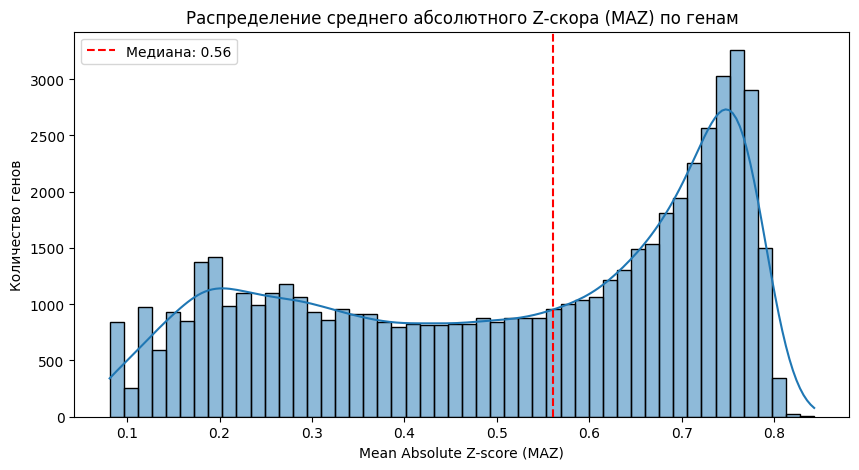

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.histplot(gene_maz, bins=50, kde=True)
plt.axvline(gene_maz.median(), color='red', linestyle='--', label=f'Медиана: {gene_maz.median():.2f}')
plt.title('Распределение среднего абсолютного Z-скора (MAZ) по генам')
plt.xlabel('Mean Absolute Z-score (MAZ)')
plt.ylabel('Количество генов')
plt.legend()
plt.savefig('gene_maz_distribution.png', dpi=120)
plt.show()

При первом приближении видно, что генов, которые в равной степени выражены у пациентов < 5000, если искать зависимость между конкретным геном (не парой) и заболеванием, возможно взять наиболее равномерно выраженные за основу